In [48]:
#Imports
import os
import scanpy as sc
import matplotlib
import tensorflow as tf
import anndata
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder


In [49]:
#---Prepare Data---
dataset_name = 'Lung_Atlas_public'
label_key = 'cell_type'
batch_key = 'batch'


#set base path to load data: goes back one directory and then into the data
base_path = os.path.join('..', 'data')

# read dataset into an anndata object:  Category - Cells of the brain
inPath = os.path.join(base_path, f"{dataset_name}.h5ad")
adata = sc.read(inPath)

Dataset before integration:


c:\Users\lklei\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


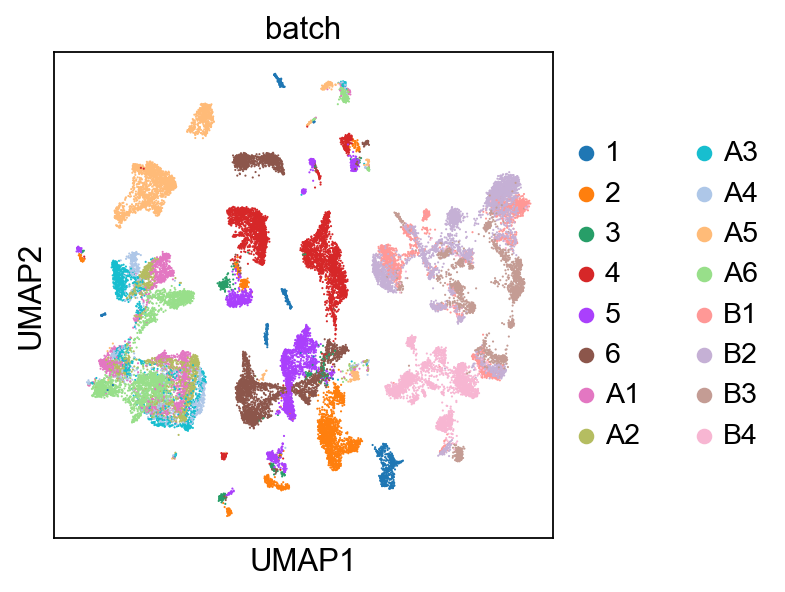

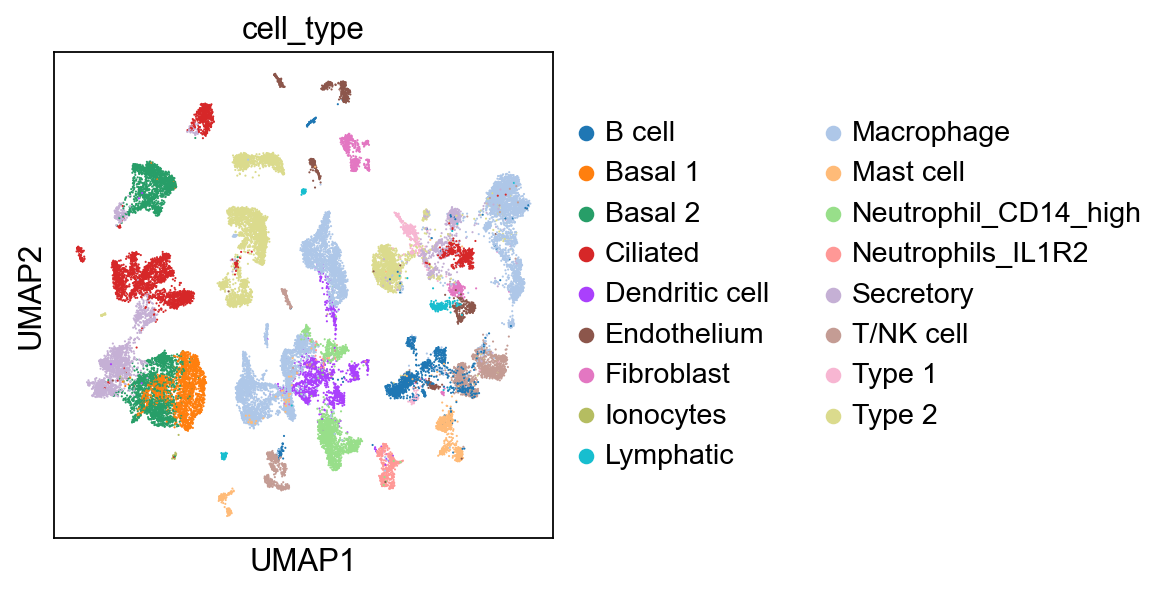

In [35]:
# --- Plot original data ---
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)
print("Dataset before integration:")
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=25)
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[batch_key], show=True, use_raw=False)
sc.pl.umap(adata, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[label_key], show=True, use_raw=False)


In [60]:
#---load models---
#set base path to load data: goes back one directory and then into the data
base_path = os.path.join('..', 'src', 'models', 'saved_models')
name = "autoencoder_final_onestep"

# load autoencoder
inPath = os.path.join(base_path, f"{name}.keras")
autoencoder = tf.keras.models.load_model(inPath)

# load discriminator
name = "discriminator"
inPath = os.path.join(base_path, f"{name}.keras")
discriminator = tf.keras.models.load_model(inPath)

# load autoencoder
name = "classifier"
inPath = os.path.join(base_path, f"{name}.keras")
classifier = tf.keras.models.load_model(inPath)


#---autoencode data---
#adata -> numpy
INPUT = adata.X.toarray()

#autoencode data
autoencoded_data = autoencoder.predict(INPUT)

#numpy -> adata
autoencoded_data_sparse = sparse.csr_matrix(autoencoded_data)
#create anndata object
integrated = anndata.AnnData(autoencoded_data_sparse)
#Take metadata from input
integrated.obs = adata.obs
integrated.var= adata.var

#---Reality Check---
print("---Reconstruction loss check---")
reconstruction_loss = tf.keras.losses.MeanSquaredError()(INPUT, autoencoded_data)
print("reconstruction loss:", float(reconstruction_loss))

print("---Discriminator accuracy check---")
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` returns a dense array
BATCH_LABELS = encoder.fit_transform(adata.obs[[batch_key]])
accuracy = discriminator.evaluate(INPUT, BATCH_LABELS, verbose=0)[1]
print("Discriminator accuracy Input:", accuracy)
accuracy = discriminator.evaluate(autoencoded_data, BATCH_LABELS, verbose=0)[1]
print("Discriminator accuracy Output:", accuracy)

print("---Classifier accuracy check---")
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` returns a dense array
CELL_LABELS = encoder.fit_transform(adata.obs[[label_key]])
accuracy = classifier.evaluate(INPUT, CELL_LABELS, verbose=0)[1]
print("Classifier accuracy Input:", accuracy)
accuracy = classifier.evaluate(autoencoded_data, CELL_LABELS, verbose=0)[1]
print("Classifier accuracy Output:", accuracy)

1015/1015 [==============================] - 3s 3ms/step
---Reconstruction loss check---
reconstruction loss: 0.03556794673204422
---Discriminator accuracy check---
Discriminator accuracy Input: 0.8550135493278503
Discriminator accuracy Output: 0.5486881136894226
---Classifier accuracy check---
Classifier accuracy Input: 0.8949556350708008
Classifier accuracy Output: 0.91451096534729


Dataset after integration using autoencoder:


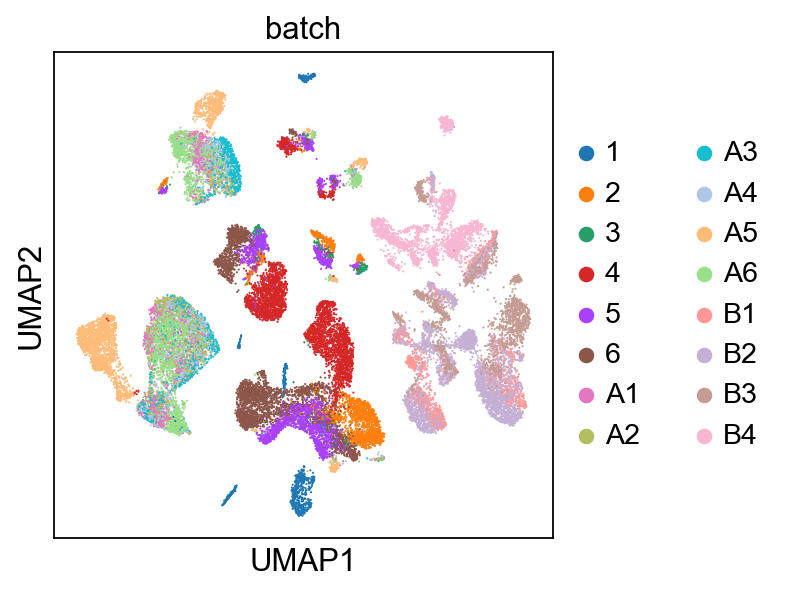

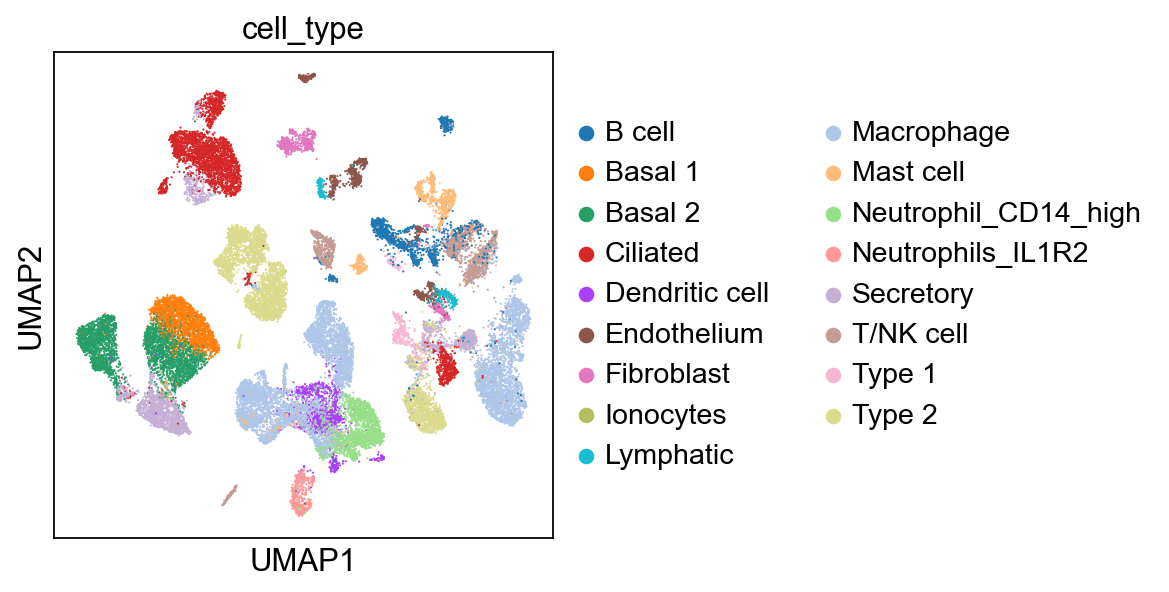

In [55]:
# --- Plot integrated data --- only mse trained
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)

print("Dataset after integration using autoencoder:")
sc.pp.pca(integrated, svd_solver="arpack")
sc.pp.neighbors(integrated, n_neighbors=25)
sc.tl.umap(integrated, random_state=42)
sc.pl.umap(integrated, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[batch_key], show=True, use_raw=False)
sc.pl.umap(integrated, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[label_key], show=True, use_raw=False)


Dataset after integration using autoencoder:


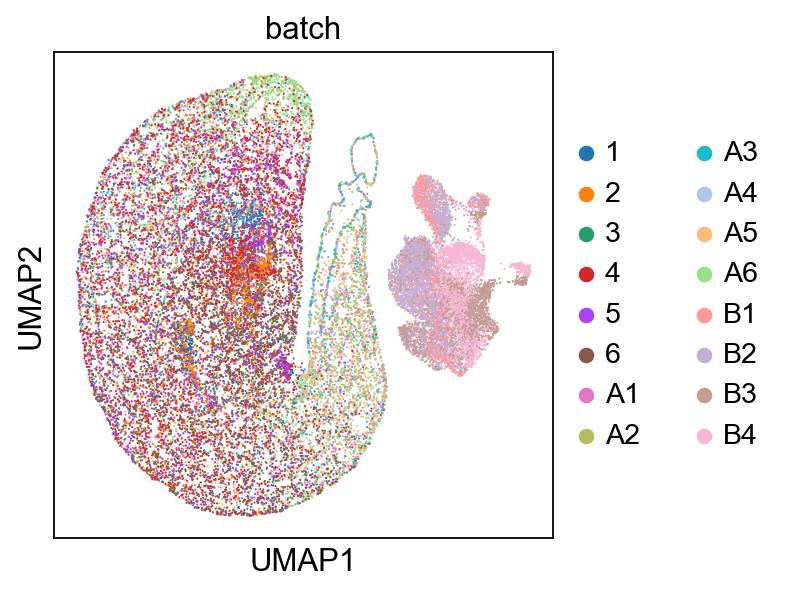

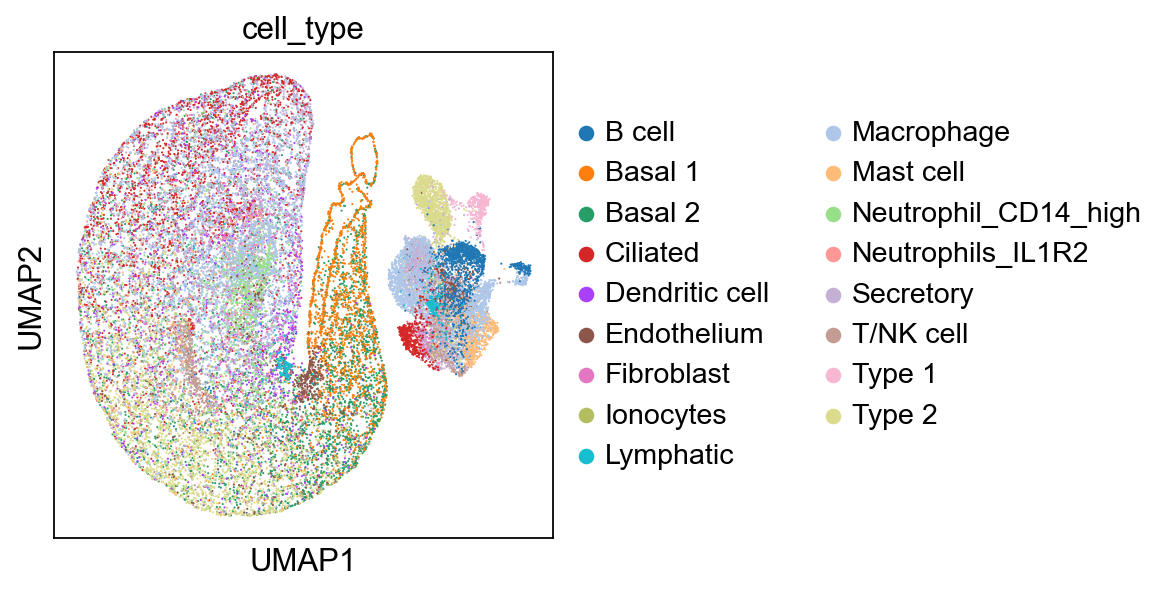

In [51]:
# --- Plot integrated data --- only adverserially trained
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)

print("Dataset after integration using autoencoder:")
sc.pp.pca(integrated, svd_solver="arpack")
sc.pp.neighbors(integrated, n_neighbors=25)
sc.tl.umap(integrated, random_state=42)
sc.pl.umap(integrated, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[batch_key], show=True, use_raw=False)
sc.pl.umap(integrated, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[label_key], show=True, use_raw=False)


Dataset after integration using autoencoder:


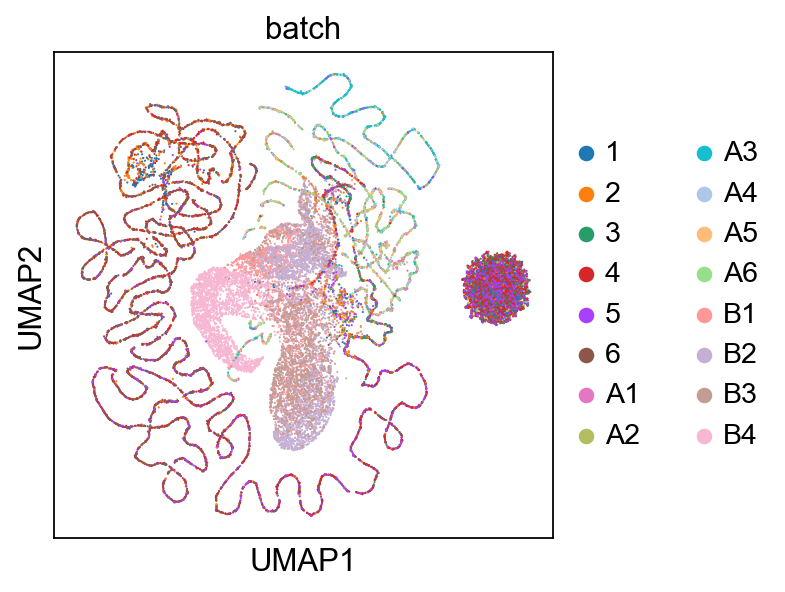

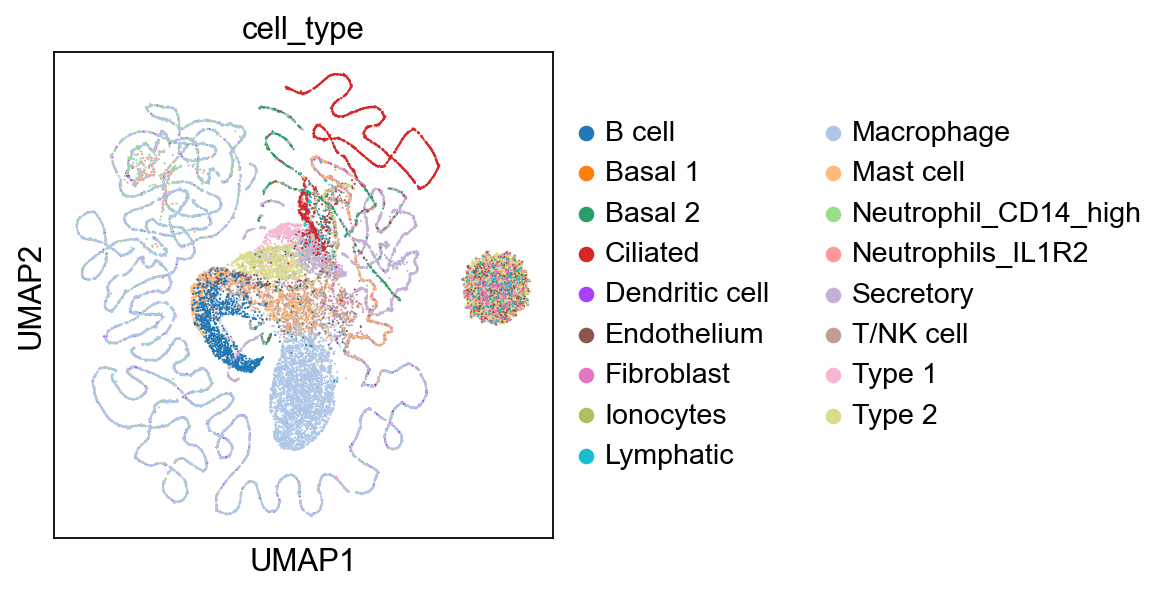

In [53]:
# --- Plot integrated data --- two step: 1.adverserially 2.reconstruction/celltype

print("Dataset after integration using autoencoder:")
sc.pp.pca(integrated, svd_solver="arpack")
sc.pp.neighbors(integrated, n_neighbors=25)
sc.tl.umap(integrated, random_state=42)
sc.pl.umap(integrated, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[batch_key], show=True, use_raw=False)
sc.pl.umap(integrated, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[label_key], show=True, use_raw=False)

Dataset after integration using autoencoder:


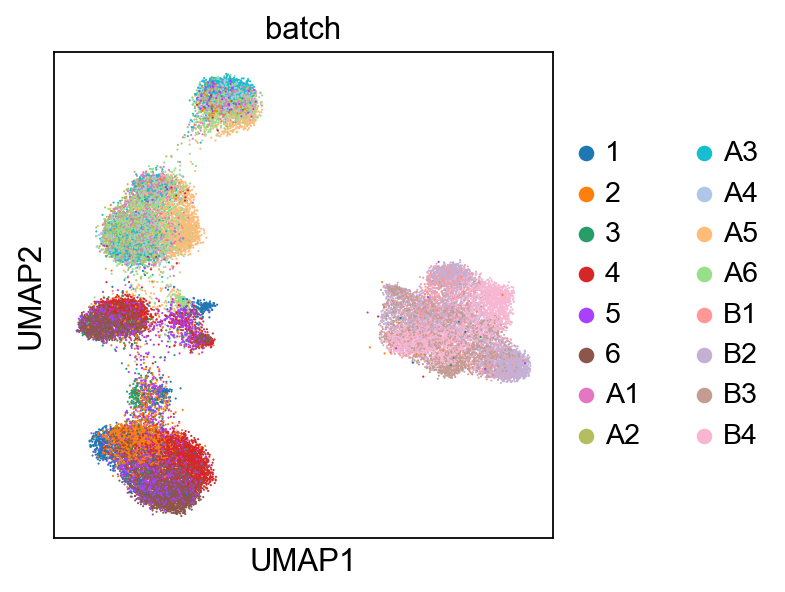

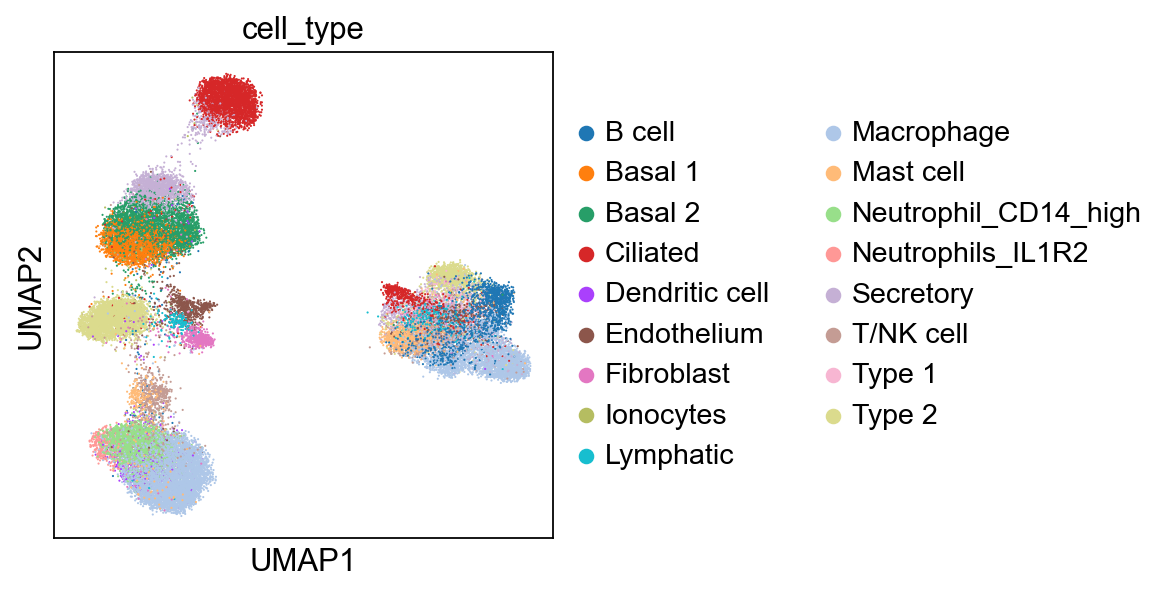

In [42]:
# --- Plot integrated data --- untrained

print("Dataset after integration using autoencoder:")
sc.pp.pca(integrated, svd_solver="arpack")
sc.pp.neighbors(integrated, n_neighbors=25)
sc.tl.umap(integrated, random_state=42)
sc.pl.umap(integrated, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[batch_key], show=True, use_raw=False)
sc.pl.umap(integrated, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[label_key], show=True, use_raw=False)


Dataset after integration using autoencoder:


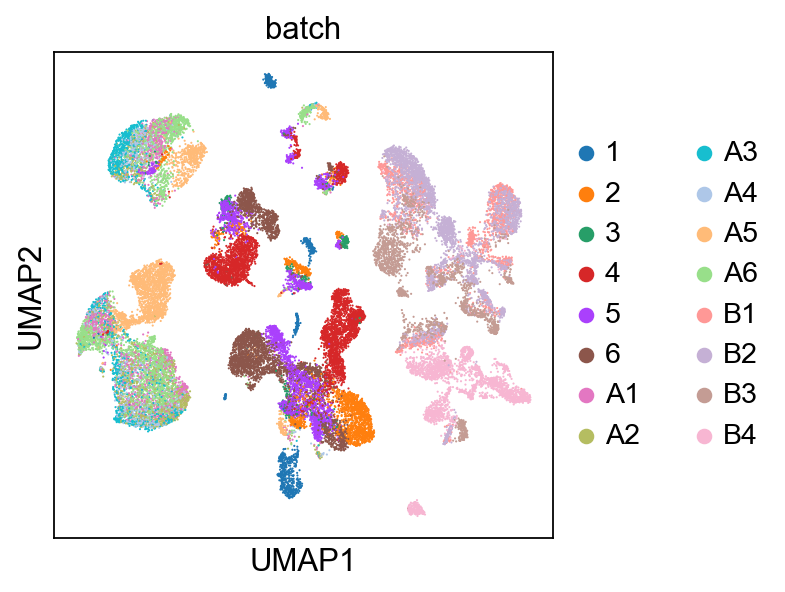

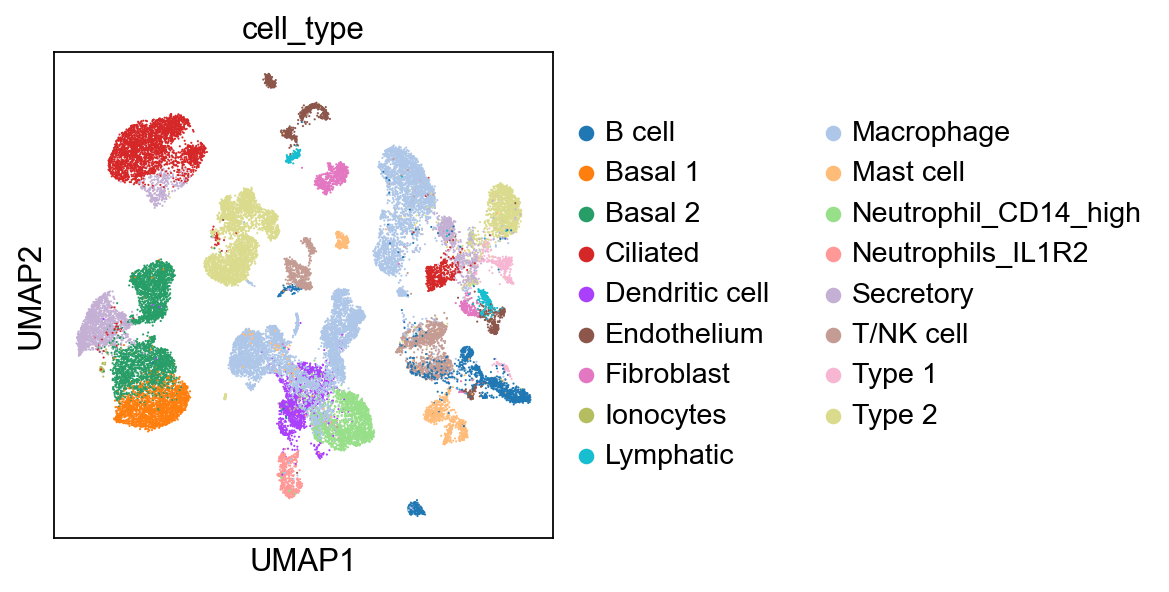

In [61]:
# --- Plot integrated data --- one-step trained

print("Dataset after integration using autoencoder:")
sc.pp.pca(integrated, svd_solver="arpack")
sc.pp.neighbors(integrated, n_neighbors=25)
sc.tl.umap(integrated, random_state=42)
sc.pl.umap(integrated, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[batch_key], show=True, use_raw=False)
sc.pl.umap(integrated, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[label_key], show=True, use_raw=False)

In [ ]:
#set base path to load data: goes back one directory and then into the data
base_path = os.path.join('..', 'src', 'models', 'saved_models')
name = "autoencoder_adverserialtrained"

# load autoencoder
inPath = os.path.join(base_path, f"{name}.keras")
autoencoder = tf.keras.models.load_model(inPath)
print(autoencoder.input_shape)

#Data preperation: adata to Tensorflow dataset
#ADATA->NUMPY
GENE_EXPRESSION = adata.X.toarray()
#One-hot encoding the Cell Types
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` returns a dense array
CELL_TYPES = encoder.fit_transform(adata.obs[[label_key]])
BATCH_LABELS = encoder.fit_transform(adata.obs[[batch_key]])

    #Combine NUMPY and One-hot encoded Batches in a Tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((GENE_EXPRESSION, CELL_TYPES, BATCH_LABELS))
#Create training batches
batch_size = 500
train_dataset = train_dataset.batch(batch_size)
    
    # Optimizer for the joint training
optimizer_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.1)
optimizer_classifier = tf.keras.optimizers.Adam(learning_rate=0.1)


for batch in train_dataset:
    #Batch number
    gene_expression, cell_labels, batch_labels = batch

reconstructed_gene_expression = autoencoder(gene_expression)
reconstruction_loss = tf.keras.losses.MeanSquaredError()(gene_expression, reconstructed_gene_expression)
lamda = 9.0

(None, 15148)


In [ ]:
reconstruction_loss*0.8+reconstruction_loss*0.8

<tf.Tensor: shape=(), dtype=float32, numpy=0.079707965>